# <center> Дипломный проект <br> Прогнозирование временных рядов трафика желтого такси Нью-Йорка

## <center> 3 Прогнозирование временного ряда со сложной сезонностью <br>

На этой неделе мы построим модель временного ряда для одной из зон.

Для прогнозирования временных рядов наиболее часто применяют регрессионные модели ARIMA.

Сначала попробуем самый простой вариант для ячейки 1231, содержащей Empire State Building.

Основная сложность работы с такими рядами  заключается в том, как учесть сложную структуру сезонности — суточной, недельной и годовой. В рамках моделей ARIMA можно учесть только одну из них. Обычно в таких случаях сезонность с самым маленьким периодом явно моделируют с помощью аримы, а все остальные учитывают за счёт регрессионной компоненты.

Для учёта недельной сезонности используются регрессионные признаки следующего вида:

$s_i = \sin \left( [1,\dots,T] * 2 \pi i/ 168 \right), $

$c_i = \cos \left( [1,\dots,T] * 2 \pi i/ 168 \right), $

$i=1,\dots, K.$

Здесь $T$— это длина моделируемого ряда, 168 — длительность недели в часах, а значение параметра KK вам предстоит подобрать самостоятельно (в зависимости от длины подготовленного ряда, можно для начала взять $K$ равным 2-5).

Аналогичные признаки можно использовать для учёта годовой сезонности. Длина года — 8766 часов.

Если в данных есть линейный или описываемый ещё какой-то простой функцией $f$ тренд, стоит добавить к регрессионным признакам вектор $[1,\dots,T] $ или, соответственно, $f([1,\dots,T])$.

### Загрузка модулей

In [2]:
import pandas as pd
from glob import glob
import os
import statsmodels.api as sm
from sklearn import linear_model
import itertools
from tqdm import tqdm
from scipy import stats

In [3]:
%pylab inline
import seaborn as sns
sns.set()

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

Возьмем обработанные данные за 3 месяца, кроме последнего:

In [4]:
def load_train_data(path_to_files,n_files):
    data_load = []
    path_files_list = sorted(glob(os.path.join(path_to_files, 'prepare_data*.csv')))
    for path_file in tqdm(path_files_list[-n_files-1:-1]):
        data_load.append(pd.read_csv(path_file, index_col=['time'],parse_dates=['time'], dtype={'region':int,'count':int}))
    return pd.concat(data_load)

In [5]:
data = load_train_data('data/Prepare_data', n_files = 3)

100%|████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


In [29]:
train_data = data[data['region'] == 1231]
train_data = train_data.drop(columns = 'region')
train_data = train_data.resample('H').sum()
T = len(train_data.index)

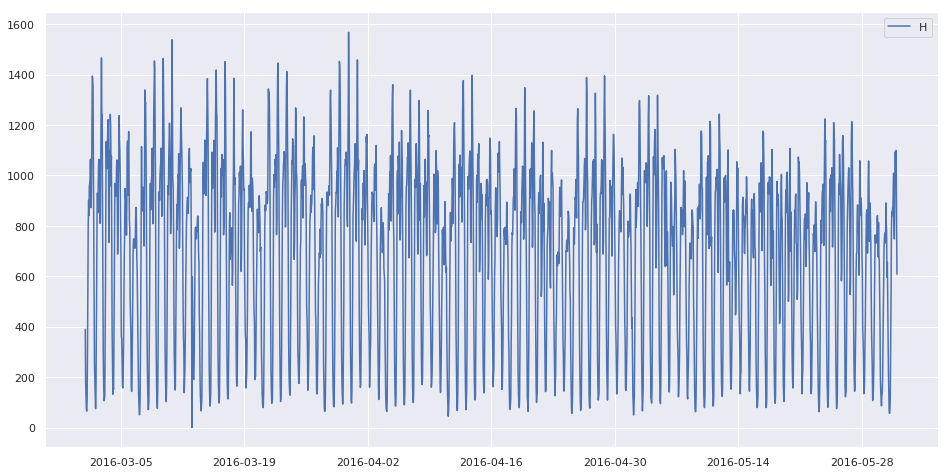

In [30]:
figure(figsize=(16,8))
#plot(train_data['count'].resample('D').sum(),label='D')
#plot(train_data['count'].resample('W').sum(),label="W")
#plot(train_data['count'].resample('M').sum(),label="M")
#plot(train_data['count'].resample('Y').sum(),label="Y")
plot(train_data['count'],label="H")
legend()
show()

### Анализ временного ряда

Для использования моделей ARIMA необходимо, чтобы ряд был стационарен.

Посмотрим на декомпозицию ряда и проверим стационарность с помощью критерия Дики-Фуллера:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1296x1152 with 0 Axes>

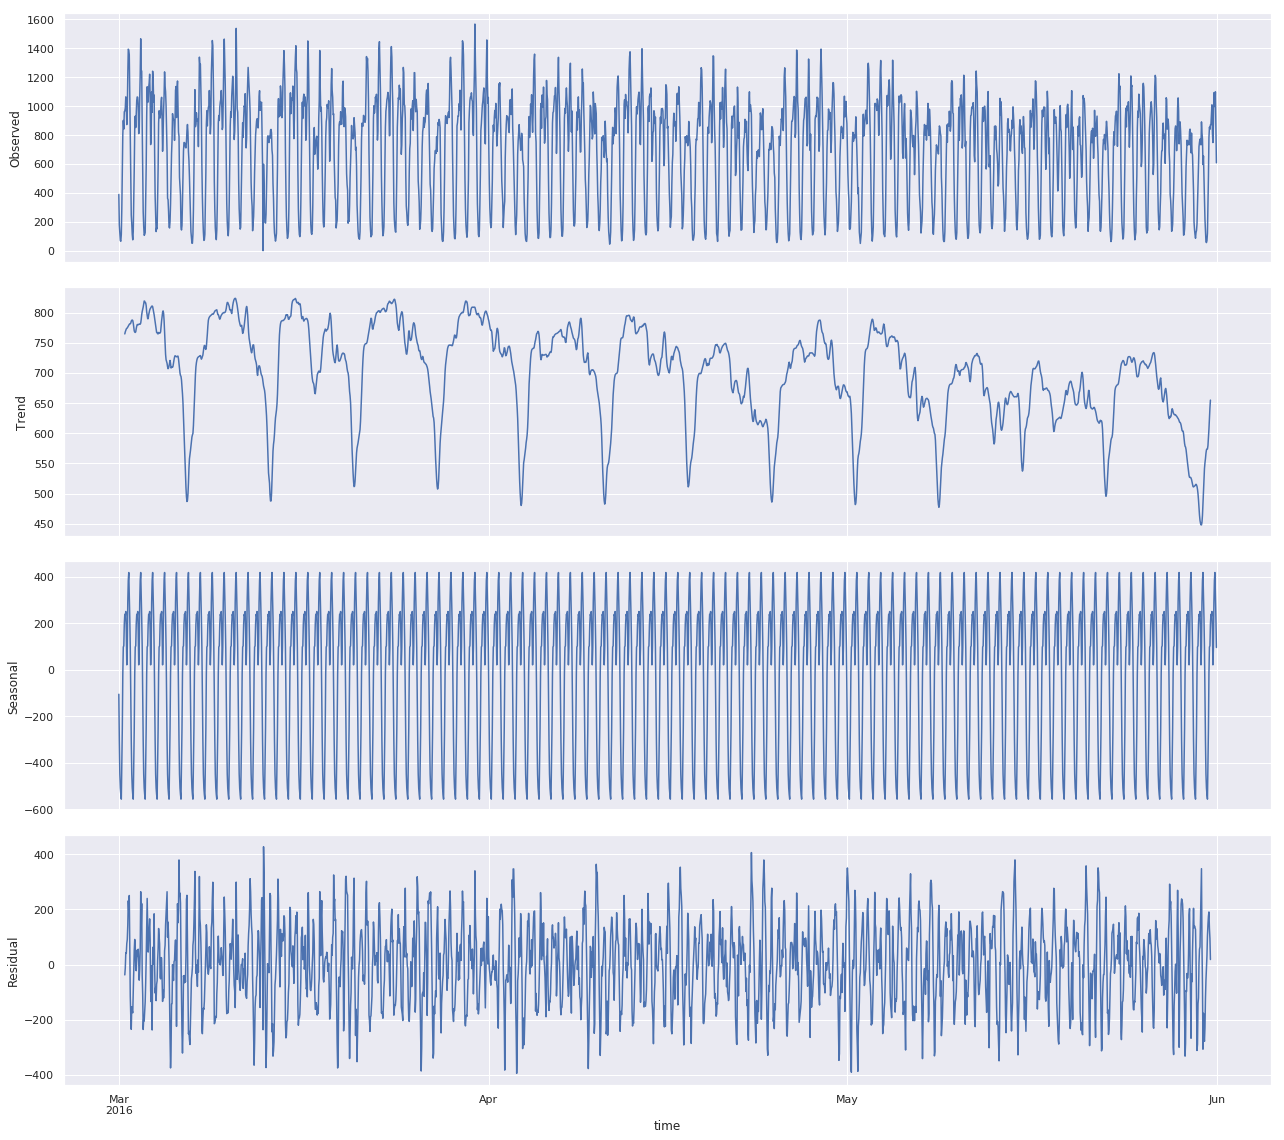

In [31]:
figure(figsize(18,16))
sm.tsa.seasonal_decompose(train_data['count']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_data['count'])[1])
show()

Хоть и гипотеза о нестационарности отвергается, видно, что ряд содержит тренд, недельную и суточную сезонность.
В модели ARIMA можно учесть только одну из них. Недельную сезонность учтем за счет за счёт регрессионной компоненты, тренд - за счет полиномиальной компоненты, а суточную непосредственно в ARIMA.

### Регрессионные признаки

Создадим два типа признаков:

- Фурье-гармоники

- Полиномы

In [32]:
def generate_exog(time_start=0, time_end, k_week, k_year, k_pol):
    T_arr = np.arange(time_start, time_end)
    exog_sin_week = np.zeros((time_end,k_week))
    exog_cos_week = np.zeros((time_end,k_week))
    exog_sin_year = np.zeros((time_end,k_year))
    exog_cos_year = np.zeros((time_end,k_year))
    exog_polinom = np.zeros((time_end,k_pol))
    
    for i in range(k_week):
        exog_sin_week[:,i] = np.sin(T_arr * 2 * pi * (i+1) / 168)
        exog_cos_week[:,i] = np.cos(T_arr * 2 * pi * (i+1) / 168)
        
    for i in range(k_year):
        exog_sin_year[:,i] = np.sin(T_arr * 2 * pi * (i+1) / 8760)
        exog_cos_year[:,i] = np.cos(T_arr * 2 * pi * (i+1) / 8760)
        
    for i in range(k_pol):
        exog_polinom[:,i] = T_arr**(i+1)

    exog = np.concatenate((exog_sin_week, exog_cos_week,
                           exog_sin_year, exog_cos_year, 
                           exog_polinom), axis=1)
    return pd.DataFrame(exog)

In [35]:
train_exog = generate_exog(time_end=len(train_data), k_week=7, k_year=3, k_pol=2)

На созданных признаках обучим линейную регрессию

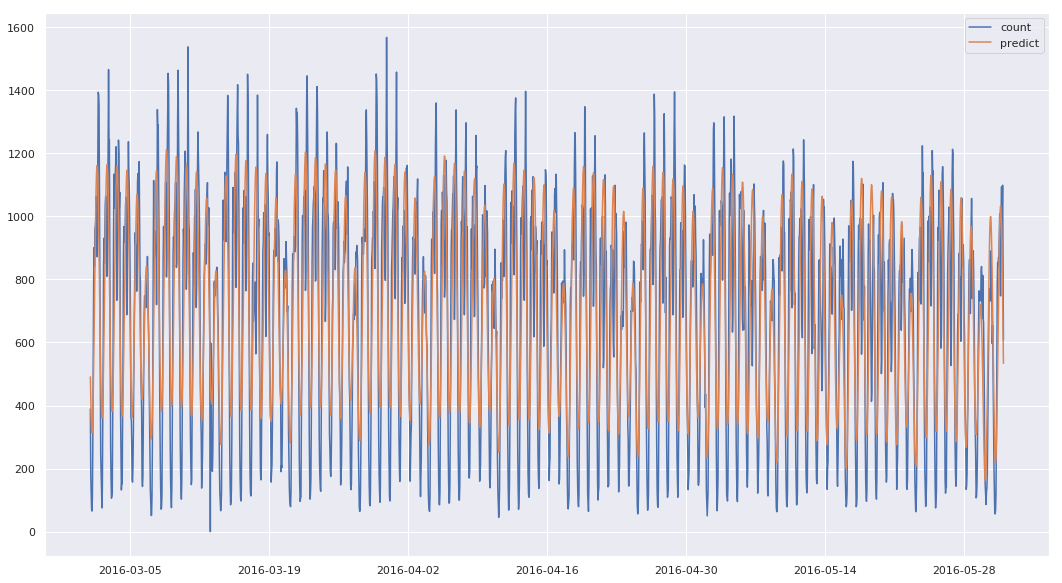

In [36]:
lin_model = linear_model.LinearRegression().fit(train_exog,train_data['count'])
train_data['predict'] = lin_model.predict(train_exog)
figure(figsize=(18,10))
plot(train_data.index,train_data['count'])
plot(train_data.index,train_data['predict'])
legend()
show()

Дальнейший анализ будем выполнять на остатках:

In [37]:
train_data['residual'] = train_data['count'] - train_data['predict']

### Стационарность

Критерий Дики-Фуллера: p=0.000000


<Figure size 1296x1152 with 0 Axes>

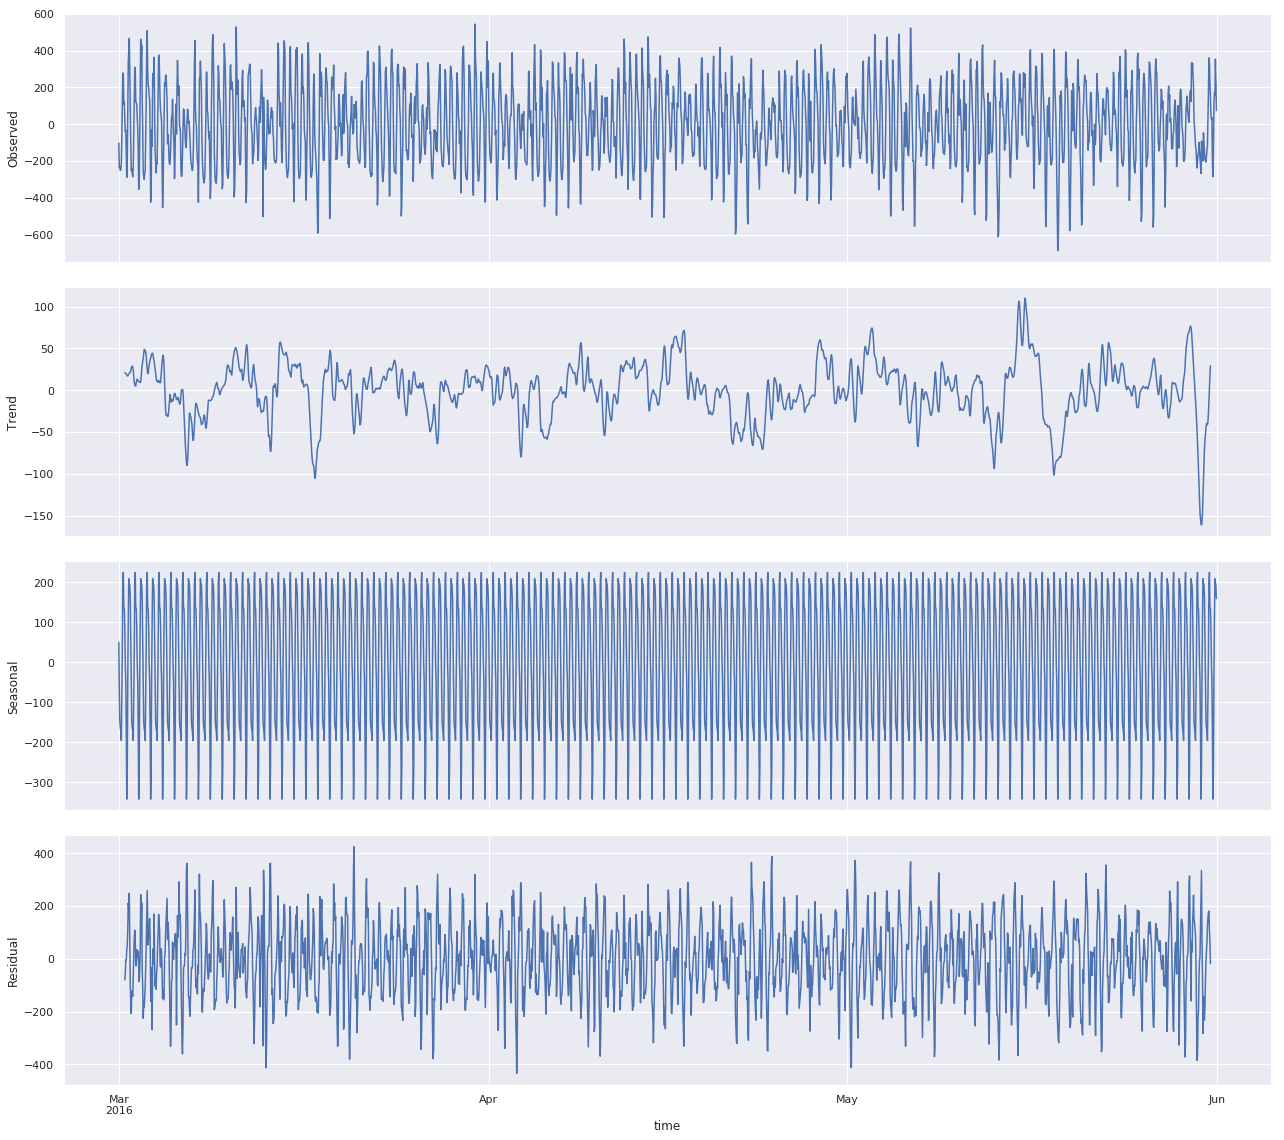

In [38]:
figure(figsize(18,16))
sm.tsa.seasonal_decompose(train_data['residual']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_data['residual'])[1])
show()

Гипотеза о нестационарности опять отвергается,но визуально ряд содержит суточную сезонность. В остатках осталась незначительная недельная сезонность.
Применим сезонное (суточное) дифференцирование.

In [39]:
train_data['residual_diff'] = train_data['residual'] - train_data['residual'].shift(24)

Критерий Дики-Фуллера: p=0.000000


<Figure size 1296x1296 with 0 Axes>

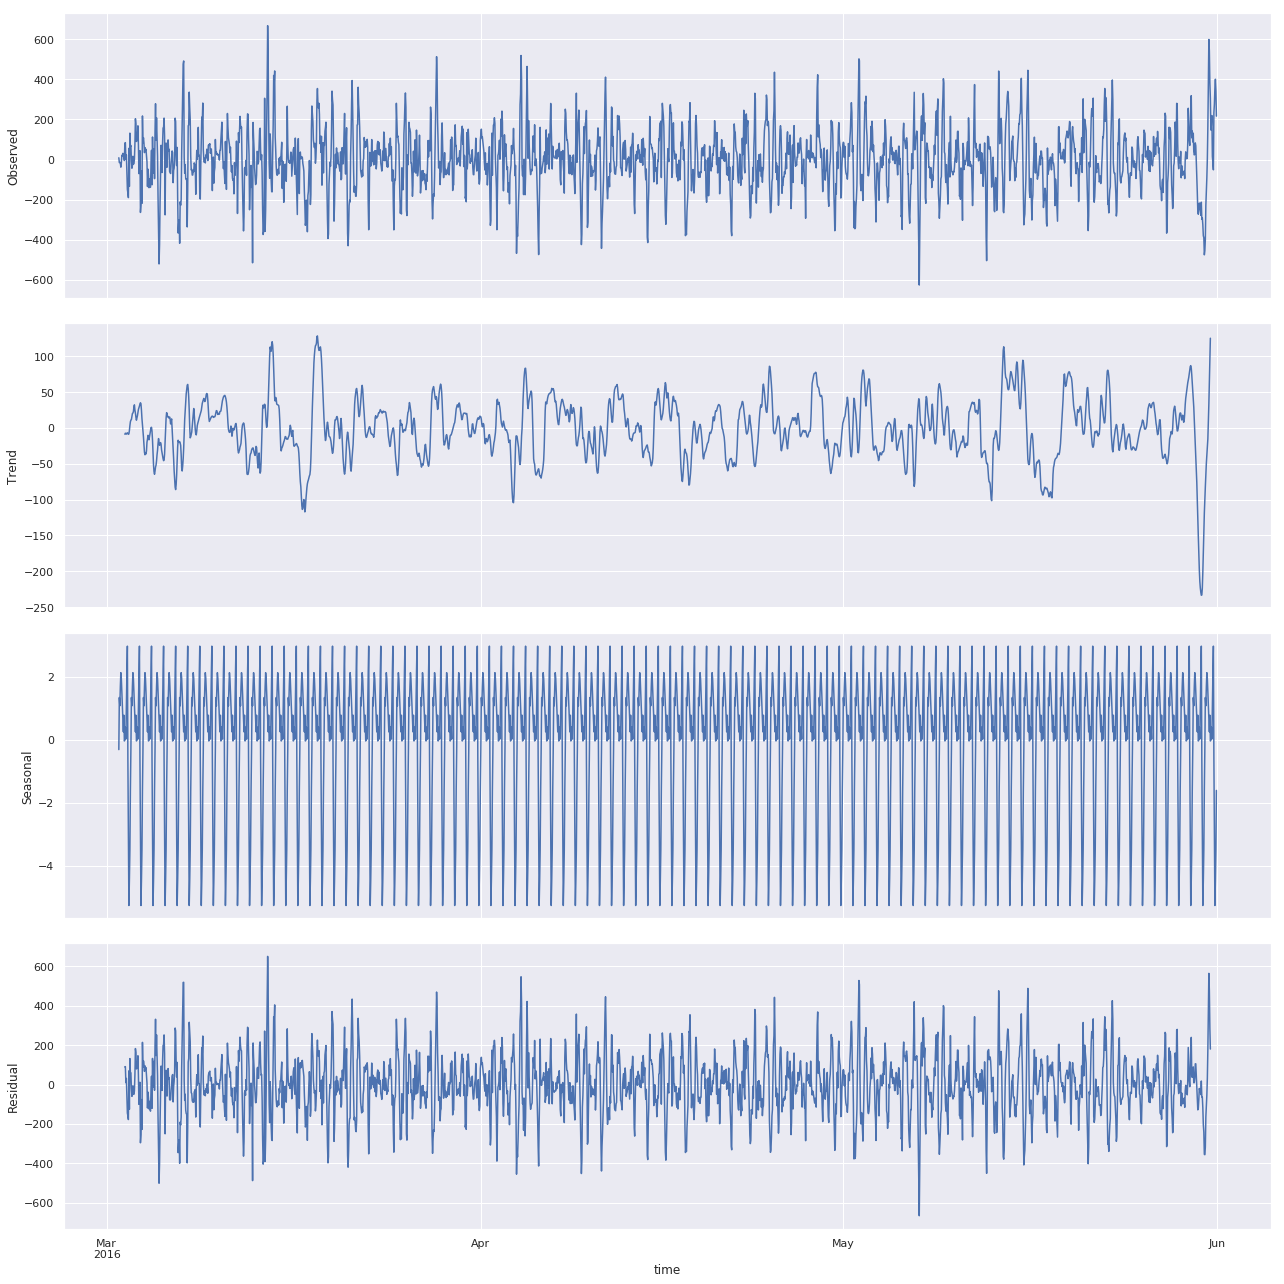

In [40]:
figure(figsize(18,18))
sm.tsa.seasonal_decompose(train_data['residual_diff'].dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_data['residual_diff'].dropna())[1])
show()

Суточная сезонность ушла и визуально ряд стал значительно лучше, остатки похожи на шум. Можно приступить к настройке ARIMA.

### Подбор модели

Параметры модели ARIMA в конечном итоге настраиваются подбором, но мы можем определить начальные приближения. Для этого построим автокорреляционные функции:

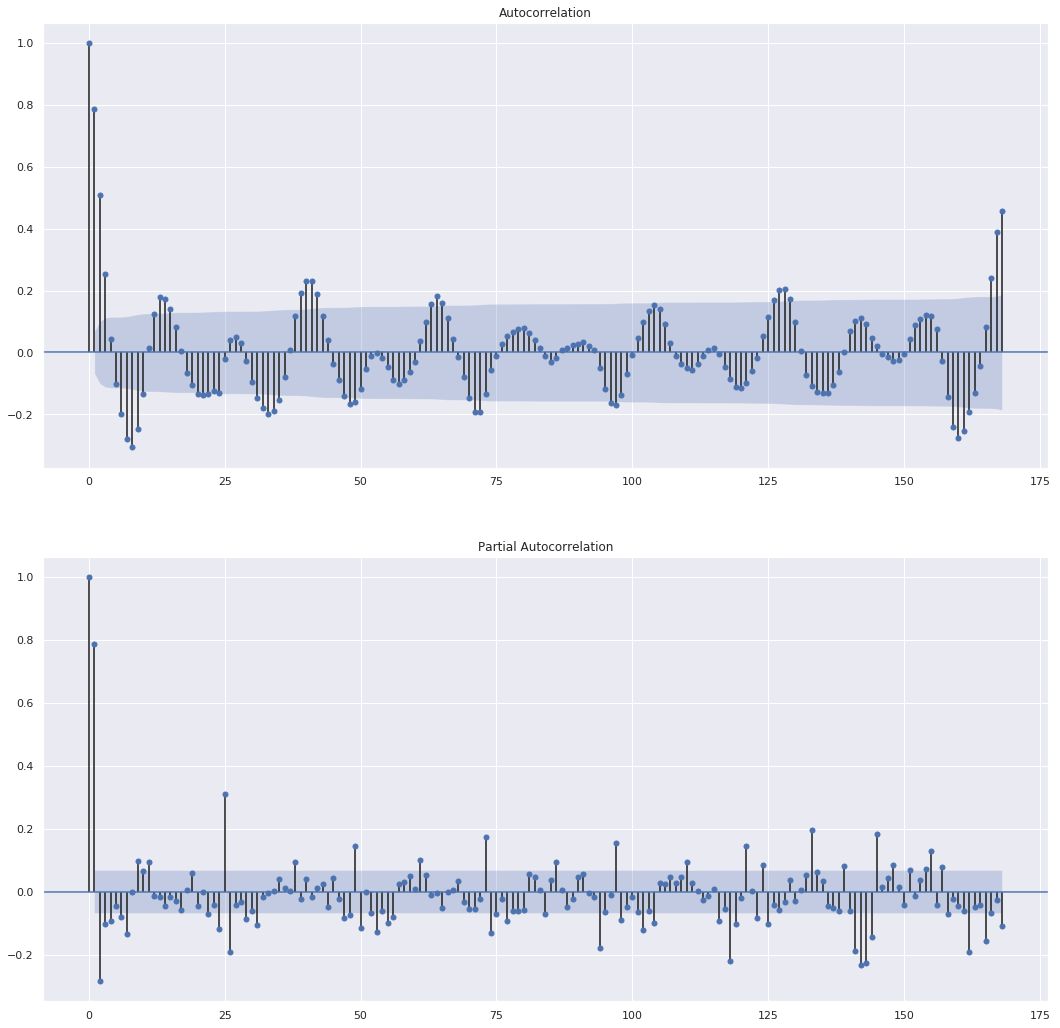

In [41]:
figure(figsize(18,18))
ax = subplot(211)
sm.graphics.tsa.plot_acf(train_data['residual_diff'][-168*5:].dropna().values, lags=168, ax=ax)
ax = subplot(212)
sm.graphics.tsa.plot_pacf(train_data['residual_diff'][-168*5:].dropna().values, lags=168, ax=ax)
show()

Начальные приближения: Q=0, q=3, P=1, p=2

In [42]:
ps = range(0, 3)
d=0
qs = range(0, 4)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [43]:
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

24

Подбирать модель надо было так:

In [44]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_data['count'].values,exog=train_exog.values,
                                        order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 24),
                                        ).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except LinAlgError:
        print('LinAlgError:', param)
        continue
    
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (2, 3, 0, 0)
wrong parameters: (2, 3, 1, 0)
CPU times: user 1h 51min 45s, sys: 21.7 s, total: 1h 52min 7s
Wall time: 28min 2s


Посмотрим на лучшую модель:

In [53]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2208
Model:             SARIMAX(0, 0, 1)x(1, 1, 0, 24)   Log Likelihood              -13980.696
Date:                            Tue, 20 Nov 2018   AIC                          28011.392
Time:                                    13:31:55   BIC                          28153.615
Sample:                                         0   HQIC                         28063.381
                                           - 2208                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            70.2519      5.291     13.278      0.000      59.882      80.621
x2            37.9189      3.251     11.664      0.000      31.547      44.291
x3             4.6840      2.351      1.992      0.046       0.076       9.292
x4           -25.9188      2.719     -9.534      0.000     -31.247     -20.590
x5           -40.1850      3.049    -13.180      0.000     -46.161     -34.209
x6            15.5851      5.137      3.034      0.002       5.517      25.653
x7             0.0005      0.048      0.010      0.992      -0.093       0.094
x8           -15.6659      6.184     -2.533      0.011     -27.786      -3.545
x9            20.2303      3.127      6.470      0.000      14.102      26.359
x10           34.7503      2.663     13.047      0.000      29.530      39.970
x11           21.5442      2.270      9.490      0.000      17.095      25.994
x12          -26.1608      2.996     -8.733      0.000     -32.032     -20.290
x13          -56.3944      5.235    -10.773      0.000     -66.655     -46.134
x14           -0.0008      1.134     -0.001      0.999      -2.223       2.221
x15        -1.545e+06      4.042  -3.82e+05      0.000   -1.55e+06   -1.55e+06
x16         1.689e+05     50.427   3349.077      0.000    1.69e+05    1.69e+05
x17         1378.3631    152.821      9.019      0.000    1078.839    1677.887
x18        -7.707e+05      4.232  -1.82e+05      0.000   -7.71e+05   -7.71e+05
x19        -1.187e+05     32.343  -3668.795      0.000   -1.19e+05   -1.19e+05
x20         2.001e+04    173.394    115.423      0.000    1.97e+04    2.04e+04
x21          863.6986      0.753   1147.342      0.000     862.223     865.174
x22           -0.2780      0.000   -859.440      0.000      -0.279      -0.277
ma.L1          0.1549      0.003     57.531      0.000       0.150       0.160
ar.S.L24      -0.0056      0.002     -3.455      0.001      -0.009      -0.002
sigma2      1.521e+04    359.335     42.329      0.000    1.45e+04    1.59e+04
===================================================================================
Ljung-Box (Q):                     2980.16   Jarque-Bera (JB):             18442.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -1.03
Prob(H) (two-sided):                  0.28   Kurtosis:                        17.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.7e+20. Standard errors may be unstable.
"""

Прогноз модели

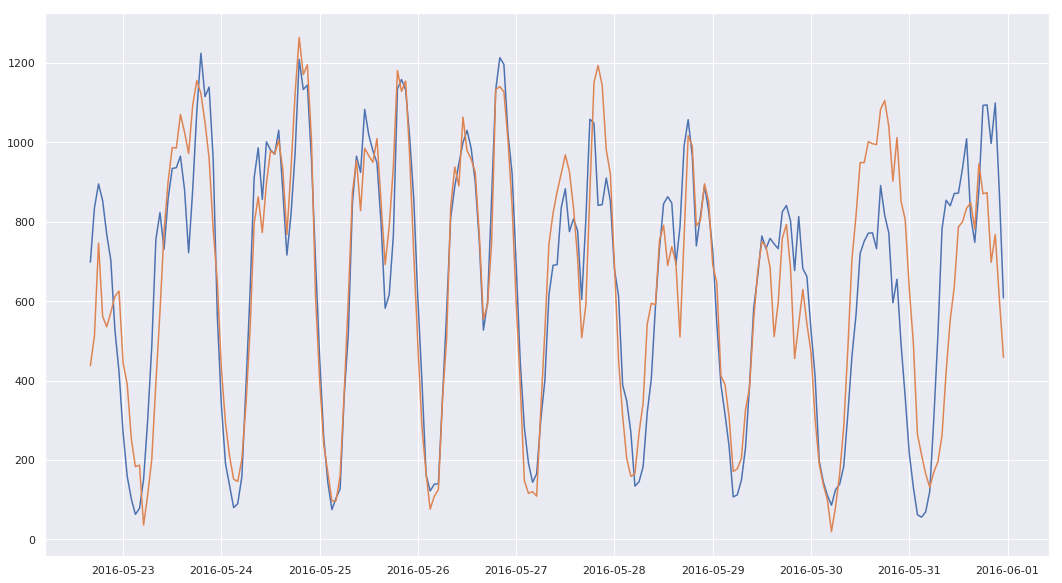

In [51]:
figure(figsize=(18,10))
plot(train_data.index[-224:], train_data['count'][-224:])
plot(train_data.index[-224:],best_model.fittedvalues[-224:])
show()

Качество модель вполне хорошее, посмотрим на остатки

Критерий Стьюдента: p=0.676237
Критерий Дики-Фуллера: p=0.000000


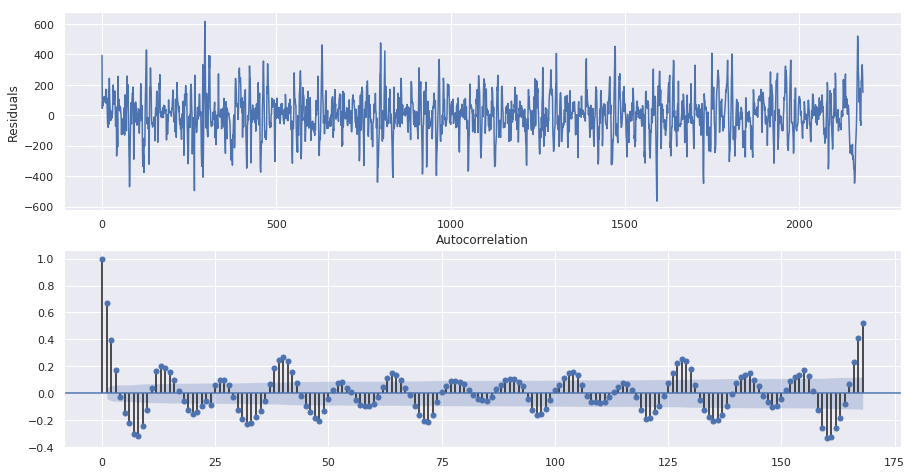

In [49]:
figure(figsize(15,8))
subplot(211)
plot(best_model.resid[25:])
ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[25:].squeeze(), lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[25:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[25:])[1])

Остатки несмещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).